In [41]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay, plot_roc_curve

from fairlearn import datasets
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate
from fairlearn.metrics import MetricFrame


In [49]:
def sensitive_pdfs(df, sensitive_features): 
    distinct_features_vals = []
    df_dict = {}
    for feature in sensitive_features:
        distinct_vals = set(df[feature].to_list())
        distinct_features_vals.append(distinct_vals)
    distinct_features_combos = list(product(*distinct_features_vals))
    for features in distinct_features_combos:
        query = " & ".join([f"{sensitive_features[i]} == '{features[i]}'" for i in range(len(sensitive_features))])
        filtered_df = df.query(query)
        key = tuple(sorted(features))
        df_dict[key] = filtered_df 
    return df_dict

In [50]:
def plot_auc(df, y_pred, y_true, name, ax=None):
    y_pred_r = np.asarray(df[y_pred]).astype(float)
    y_true_r = np.asarray(df[y_true]).astype(int)

    fpr, tpr, _ = roc_curve(y_true_r, y_pred_r, pos_label=1)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot(ax=ax)
    return display

# Load data

In [51]:
# Load data
data = datasets.fetch_adult(as_frame=True)['data']
target = datasets.fetch_adult(as_frame=True)['target']

In [52]:
assert(len(target == len(data)))
print(len(target))
print(set(target))
data.head(3)
df = data.copy()

48842
{'<=50K', '>50K'}


# Run Model Example

In [53]:
# Extract into X, y and A
sensitive_features = ['sex', 'race']
data_cols = [x for x in data if x not in sensitive_features]

# Predictors
ohe = OneHotEncoder()
X = ohe.fit_transform(data[data_cols])

le = LabelEncoder()
y = le.fit_transform(target)
A = data[sensitive_features]

In [54]:
# Split into test and train, making sure we have sequential indices in the results
X_train, X_test, y_train, y_test, A_train, A_test = \
    train_test_split(X, y, A, test_size=0.33, random_state=123)

# X_train = X_train.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# A_train = A_train.reset_index(drop=True)
# X_test = X_test.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)
# A_test = A_test.reset_index(drop=True)

No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.923


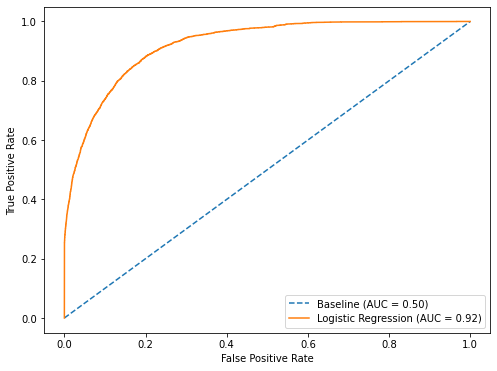

In [55]:
# Fit unmitigated model
clf = LogisticRegression(solver='liblinear', fit_intercept=True)
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Get probabilies for positive prediction
y_true = y_pred_proba[:, 1]

# Get probabiliies for random (no skill)
ns_probs = [0 for n in range(len(y_test))]

# calculate AUC scores
ns_auc = roc_auc_score(y_test, ns_probs)
roc_auc = roc_auc_score(y_test, y_true)

# Summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic Regression: ROC AUC=%.3f' % (roc_auc))
 
# Get overall roc curve points
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr, tpr, _ = roc_curve(y_test, y_true)

# Plot ROC curve

#figure, ax = plt.subplots()
plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline (AUC = 0.50)')
#display = plot_roc_curve(clf, X_test, y_test, sample_weight=None, drop_intermediate=True, response_method='auto', name="Logistic Regression", ax=ax, pos_label=1)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot(ax=ax)
plt.show()


# ROC Curves by Sensitive Values - Reference Code

In [120]:
# Concat predictions with sensitive values
pdf = pd.DataFrame({'y_test': y_test, 'y_true': y_true,'y_pred': y_pred,})
pdf = pd.concat([pdf, A_test.reset_index(drop=True)], axis=1)

# Generate grouped PDFs
# TO DO - Use metricframe class 

sensitive_pdfs_dict = sensitive_pdfs(pdf, sensitive_features)

In [129]:
group.head(3)

,y_test,y_true,y_pred,sex,race
1,0,0.000232,0,Male,White
4,0,0.017699,0,Male,White
6,0,0.318911,0,Male,White


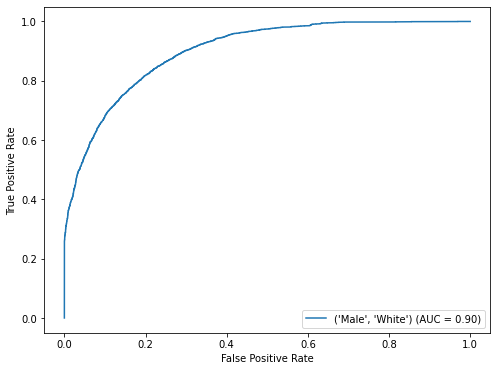

In [127]:
name = ('Male', 'White')
group = sensitive_pdfs_dict[name]
plt.figure(figsize=(8, 6))
ax = plt.gca()
group_plot = plot_auc(group,"y_true","y_test", name, ax)
plt.show()

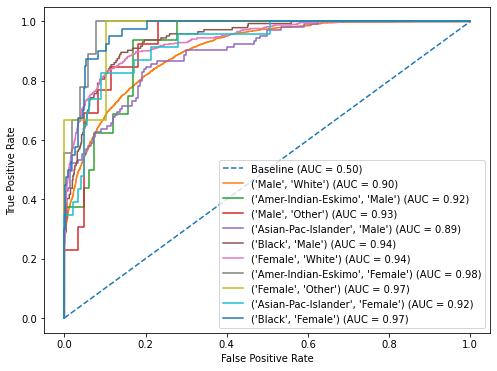

In [132]:
sensitive_pdfs_dict=sensitive_pdfs(pdf, sensitive_features)
plt.figure(figsize=(8, 6))
ax = plt.gca()
ns_probs = [0 for n in range(len(pdf))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline (AUC = 0.50)')
for grouping in sensitive_pdfs_dict: 
    group_plot = plot_auc(sensitive_pdfs_dict[grouping],"y_true", "y_test", grouping, ax)

# ROC Curves by Sensitive Values - MetricFrame

In [136]:
MetricFrame()

TypeError: __init__() missing 3 required positional arguments: 'metric', 'y_true', and 'y_pred'